In [18]:
# 导入必要的库
import pandas as pd
import numpy as np
import os
import holidays

# 第一部分：数据准备与特征工程 ------------------------------------------------

# 生成南澳节假日（Australia, South Australia）2022–2025
# 使用holidays库获取南澳大利亚的官方节假日
aus_holidays = holidays.Australia(prov='SA', years=[2022, 2023, 2024, 2025])
sa_holidays = pd.to_datetime(list(aus_holidays.keys()))

# 加载并合并2022-2025年的犯罪数据
print("正在加载犯罪数据...")
df1 = pd.read_csv('Crime Statistics/2022-23_data_sa_crime.csv')
df2 = pd.read_csv('Crime Statistics/2023-24_data_sa_crime.csv')
df3 = pd.read_csv('Crime Statistics/2024-25_data_sa_crime.csv')
df = pd.concat([df1, df2, df3], ignore_index=True)
print(f"加载完成，共{len(df)}条记录")

# 标准化列名，确保一致性
df.rename(columns={
    'Offence Level 1 Description': 'Offence Level 1',  # 犯罪类型一级描述
    'Offence Level 2 Description': 'Offence Level 2',  # 犯罪类型二级描述
    'Offence Level 3 Description': 'Offence Level 3',  # 犯罪类型三级描述
    'Offence count': 'Offence Count',                  # 犯罪数量
    'Suburb - Incident': 'Suburb',                     # 犯罪发生郊区
}, inplace=True)

# 清理邮政编码：移除非数字或无效条目
print("清理数据...")
df['Postcode - Incident'] = pd.to_numeric(df['Postcode - Incident'], errors='coerce')
df = df.dropna(subset=['Postcode - Incident'])
df['Postcode - Incident'] = df['Postcode - Incident'].astype(int)

# 解析报告日期并提取月份
# 使用dayfirst=True确保日期格式为日/月/年
df['Reported Date'] = pd.to_datetime(df['Reported Date'], dayfirst=True, errors='coerce')
df['Month'] = df['Reported Date'].dt.to_period('M').dt.to_timestamp()

# 确保输出目录存在
os.makedirs('Outputs', exist_ok=True)

# 第二部分：特征工程 --------------------------------------------------------

print("开始特征工程...")
# 步骤1: 按郊区×犯罪类型一级×犯罪类型二级×月份聚合数据
# 这样可以得到每个组合的犯罪总数
model_df = df.groupby(['Suburb', 'Offence Level 1', 'Offence Level 2', 'Month'])['Offence Count'].sum().reset_index()
model_df = model_df.rename(columns={'Offence Count': 'offence_count'})
model_df = model_df.sort_values(by=['Suburb', 'Offence Level 1', 'Offence Level 2', 'Month'])

# 步骤2: 创建lag_1到lag_12特征，捕捉历史犯罪数量模式
# 这些滞后特征对于时间序列预测非常重要
print("创建时间滞后特征...")
for lag in range(1, 13):
    model_df[f'lag_{lag}'] = model_df.groupby(['Suburb', 'Offence Level 1', 'Offence Level 2'])['offence_count'].shift(
        lag)

# 步骤3: 删除任何缺少滞后值的行
# 这些通常是时间序列开始的几个月，因为它们没有足够的历史数据
lag_cols = [f'lag_{i}' for i in range(1, 13)]
model_df = model_df.dropna(subset=lag_cols)

# 步骤4: 创建统计特征
# 计算最近3个月的平均值和标准差，捕捉短期趋势和波动性
model_df['avg_lag_3'] = model_df[[f'lag_{i}' for i in range(1, 4)]].mean(axis=1)
model_df['std_lag_3'] = model_df[[f'lag_{i}' for i in range(1, 4)]].std(axis=1)

# 步骤5: 添加节假日特征
# 构建节假日DataFrame
print("添加节假日特征...")
holiday_df = pd.DataFrame({'Holiday': sa_holidays})
holiday_df['Month'] = holiday_df['Holiday'].dt.to_period('M').dt.to_timestamp()

# 统计每月节假日数量
holiday_counts = holiday_df.groupby('Month').size().reset_index(name='holiday_days')

# 合并到模型数据
model_df = model_df.merge(holiday_counts, on='Month', how='left')
model_df['holiday_days'] = model_df['holiday_days'].fillna(0).astype(int)

# 步骤6: 提取月份数字（1-12）作为季节性特征
model_df['month'] = model_df['Month'].dt.month

# 步骤7: 保存处理后的数据到CSV文件
model_df.to_csv('crime_model_data.csv', index=False)
print("✅ 特征工程完成，数据已导出到crime_model_data.csv")


正在加载犯罪数据...
加载完成，共269630条记录
清理数据...
开始特征工程...
创建时间滞后特征...
添加节假日特征...
✅ 特征工程完成，数据已导出到crime_model_data.csv


In [19]:
# 第三部分：数据分割 --------------------------------------------------------

print("开始数据分割...")
# 按时间点分割数据集为训练集和测试集
# 使用2025-01-01作为分割点，之前的数据作为训练集，之后的数据作为测试集
split_date = pd.to_datetime('2025-01-01')
train_df = model_df[model_df['Month'] < split_date]
test_df = model_df[model_df['Month'] >= split_date]

# 打印训练集和测试集的大小，检查分割是否合理
print(f"训练集大小: {train_df.shape}, 测试集大小: {test_df.shape}")

# 保存训练集和测试集到CSV文件，方便后续使用
train_df.to_csv('Outputs/train.csv', index=False)
test_df.to_csv('Outputs/test.csv', index=False)
print("✅ 训练集和测试集已保存到Outputs目录")


开始数据分割...
训练集大小: (22525, 21), 测试集大小: (4613, 21)
✅ 训练集和测试集已保存到Outputs目录


In [20]:
# 第四部分：模型训练与评估 ------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("开始模型训练与评估...")

# 定义评估指标函数 -----------------------------------------------------

# 定义MAPE和SMAPE指标函数，处理零值情况
def calculate_mape(y_true, y_pred):
    """
    计算MAPE (Mean Absolute Percentage Error)，处理零值情况
    
    MAPE是一种常用的预测评估指标，表示预测值与实际值之间的平均百分比误差。
    但MAPE在处理实际值为零的情况时会出现除零错误，因此需要特殊处理。
    
    参数:
        y_true: 实际值数组
        y_pred: 预测值数组
        
    返回:
        平均百分比误差（百分比形式）
    """
    # 创建非零真实值的掩码
    mask = y_true != 0
    
    if not np.any(mask):
        return np.nan  # 如果所有真实值都是零，返回NaN
    
    # 只对非零值计算百分比误差
    percentage_errors = np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])
    
    # 返回平均百分比误差
    return np.mean(percentage_errors) * 100  # 乘以100转换为百分比

def calculate_smape(y_true, y_pred):
    """
    计算SMAPE (Symmetric Mean Absolute Percentage Error)，更好地处理零值
    
    SMAPE是MAPE的对称版本，对预测值过大或过小的惩罚是一样的，
    并且通过在分母中同时使用实际值和预测值，可以更好地处理零值情况。
    
    参数:
        y_true: 实际值数组
        y_pred: 预测值数组
        
    返回:
        对称平均百分比误差（百分比形式）
    """
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

# 数据聚合与准备 -----------------------------------------------------

print("准备模型训练数据...")
# 将数据聚合到总犯罪数级别
# 这样可以预测每个郊区每月的总犯罪数，而不是细分到具体犯罪类型
feature_cols = [f'lag_{i}' for i in range(1, 13)] + ['avg_lag_3', 'std_lag_3', 'holiday_days', 'month']
group_keys = ['Month', 'Suburb']

# 聚合训练集
y_train_total = train_df.groupby(group_keys)['offence_count'].sum().reset_index(name='offence_count')
X_train_total = train_df.groupby(group_keys)[feature_cols].mean().reset_index()
train_merged = pd.merge(X_train_total, y_train_total, on=group_keys)

# 聚合测试集
y_test_total = test_df.groupby(group_keys)['offence_count'].sum().reset_index(name='offence_count')
X_test_total = test_df.groupby(group_keys)[feature_cols].mean().reset_index()
test_merged = pd.merge(X_test_total, y_test_total, on=group_keys)

# 提取特征和目标变量
X_train = train_merged[feature_cols]
y_train = train_merged['offence_count']
X_test = test_merged[feature_cols]
y_test = test_merged['offence_count']

print(f"训练数据准备完成: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"测试数据准备完成: X_test: {X_test.shape}, y_test: {y_test.shape}")

# 注意：上述聚合逻辑将模型变为总犯罪数级别预测，而不是细分犯罪类型级别

def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    """
    训练模型并评估性能，包括MAE、RMSE、R²、MAPE和SMAPE指标
    
    参数:
        model: 机器学习模型
        X_train, y_train: 训练数据
        X_test, y_test: 测试数据
        name: 模型名称
    
    返回:
        包含评估指标的字典
    """
    # 训练模型
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    # 计算标准评估指标
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)
    
    # 计算新增的百分比误差指标
    mape = calculate_mape(y_test, preds)
    smape = calculate_smape(y_test, preds)
    
    # 打印评估结果
    print(f"📊 {name}")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  SMAPE: {smape:.2f}%")
    print("-" * 30)
    
    # 返回包含所有指标的字典
    return {
        'Model': name, 
        'MAE': mae, 
        'RMSE': rmse, 
        'R2': r2,
        'MAPE': mape,
        'SMAPE': smape
    }


# 模型训练与基础评估 -----------------------------------------------------

print("训练和评估基础模型...")
# 创建结果列表，用于存储所有模型的评估结果
results = []

# 训练并评估线性回归模型
print("1. 训练线性回归模型...")
results.append(evaluate_model(LinearRegression(), X_train, y_train, X_test, y_test, "线性回归"))

# 训练并评估随机森林模型
print("2. 训练随机森林模型...")
results.append(
    evaluate_model(RandomForestRegressor(random_state=42), X_train, y_train, X_test, y_test, "随机森林"))

# 训练并评估XGBoost模型
print("3. 训练XGBoost模型...")
results.append(evaluate_model(XGBRegressor(random_state=42), X_train, y_train, X_test, y_test, "XGBoost"))

# 创建结果DataFrame并保存到CSV
results_df = pd.DataFrame(results)
results_df.to_csv('Outputs/model_results.csv', index=False)

print("✅ 模型评估结果已保存到 Outputs/model_results.csv")


开始模型训练与评估...
准备模型训练数据...
训练数据准备完成: X_train: (7341, 16), y_train: (7341,)
测试数据准备完成: X_test: (1390, 16), y_test: (1390,)
训练和评估基础模型...
1. 训练线性回归模型...
📊 线性回归
  MAE: 7.80
  RMSE: 13.70
  R²: 0.8981
  MAPE: 88.29%
  SMAPE: 86.80%
------------------------------
2. 训练随机森林模型...
📊 随机森林
  MAE: 5.72
  RMSE: 11.30
  R²: 0.9306
  MAPE: 55.35%
  SMAPE: 38.11%
------------------------------
3. 训练XGBoost模型...
📊 XGBoost
  MAE: 5.89
  RMSE: 12.17
  R²: 0.9196
  MAPE: 51.70%
  SMAPE: 38.00%
------------------------------
✅ 模型评估结果已保存到 Outputs/model_results.csv


开始模型预测可视化...
重新训练模型并生成预测...
绘制月度预测对比图...


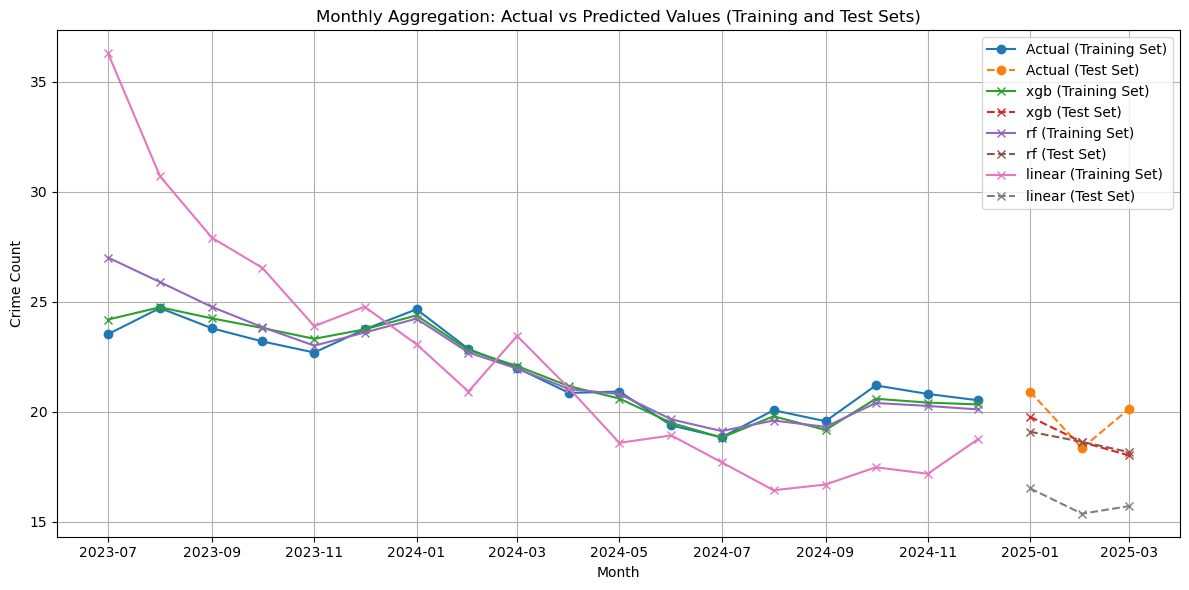

分析XGBoost残差分布...


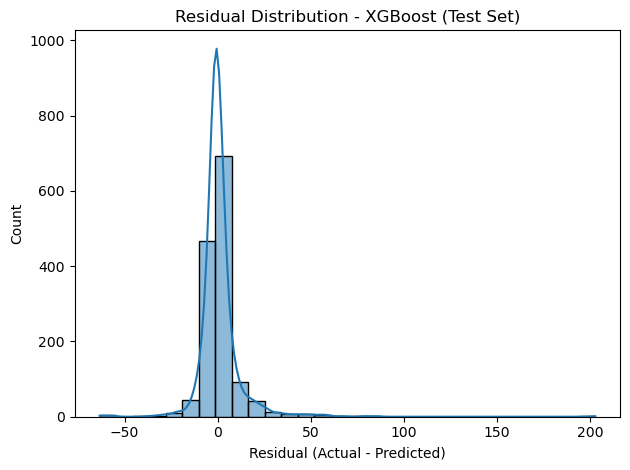

分析各郊区预测误差...
预测误差最大的前10个郊区:
Suburb
ADELAIDE          97.737447
PORT AUGUSTA      59.819191
MOUNT GAMBIER     59.235079
SALISBURY         42.670413
PORT LINCOLN      39.912646
DAVOREN PARK      34.169749
CEDUNA            34.112690
SMITHFIELD        34.079775
MURRAY BRIDGE     26.158930
WHYALLA NORRIE    26.091067
Name: error_xgb, dtype: float64
计算相对误差...
绘制相对误差前10的郊区...


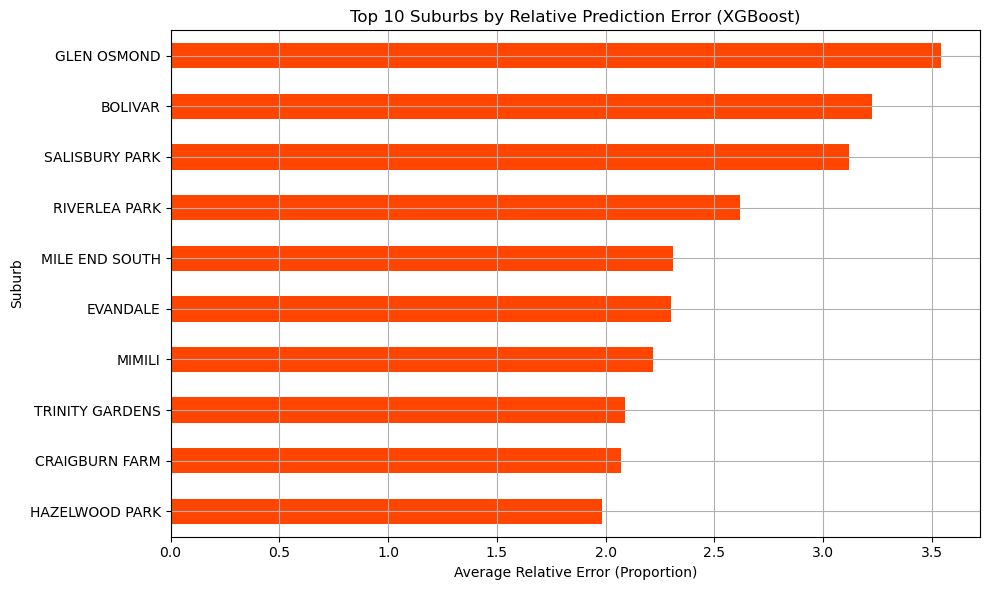

In [26]:
# 第五部分：模型预测可视化 ------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

print("开始模型预测可视化...")

# 重新训练模型以提取训练集和测试集的预测结果
print("重新训练模型并生成预测...")
linear_model = LinearRegression().fit(X_train, y_train)
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42
).fit(X_train, y_train)
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=5,
    random_state=42
).fit(X_train, y_train)

# 为训练集生成预测
train_merged['pred_linear'] = linear_model.predict(X_train)
train_merged['pred_rf'] = rf_model.predict(X_train)
train_merged['pred_xgb'] = xgb_model.predict(X_train)

# 为测试集生成预测
test_merged['pred_linear'] = linear_model.predict(X_test)
test_merged['pred_rf'] = rf_model.predict(X_test)
test_merged['pred_xgb'] = xgb_model.predict(X_test)

# 合并训练集和测试集用于绘图
train_merged['Set'] = 'Training Set'
test_merged['Set'] = 'Test Set'
compare_all = pd.concat([train_merged, test_merged], ignore_index=True)

# 可视化1: 月度聚合预测与实际值对比
print("绘制月度预测对比图...")
monthly = compare_all.groupby(['Month', 'Set'])[
    ['offence_count', 'pred_linear', 'pred_rf', 'pred_xgb']
].mean().reset_index()

plt.figure(figsize=(12, 6))
for model in ['offence_count', 'pred_xgb', 'pred_rf', 'pred_linear']:
    for subset in ['Training Set', 'Test Set']:
        subset_data = monthly[monthly['Set'] == subset]
        linestyle = '-' if subset == 'Training Set' else '--'
        model_label = 'Actual' if model == 'offence_count' else model.replace('pred_', '')
        plt.plot(subset_data['Month'], subset_data[model],
                 marker='o' if model == 'offence_count' else 'x',
                 linestyle=linestyle,
                 label=f"{model_label} ({subset})")

plt.title("Monthly Aggregation: Actual vs Predicted Values (Training and Test Sets)")
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Outputs/monthly_predictions_train_test.png")
plt.show()

# 可视化2: XGBoost在测试集上的残差分布
print("分析XGBoost残差分布...")
test_merged['residual_xgb'] = test_merged['offence_count'] - test_merged['pred_xgb']
sns.histplot(test_merged['residual_xgb'], bins=30, kde=True)
plt.title("Residual Distribution - XGBoost (Test Set)")
plt.xlabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.savefig("Outputs/xgb_residuals_test.png")
plt.show()

# 可视化3: 按郊区分析预测误差
print("分析各郊区预测误差...")
test_merged['error_xgb'] = np.abs(test_merged['offence_count'] - test_merged['pred_xgb'])
suburb_errors = test_merged.groupby('Suburb')['error_xgb'].mean().sort_values(ascending=False)
print("预测误差最大的前10个郊区:")
print(suburb_errors.head(10))

# 可视化4: 相对误差分析（按郊区的比例误差）
print("计算相对误差...")
test_merged['rel_error_xgb'] = np.abs(test_merged['offence_count'] - test_merged['pred_xgb']) / test_merged[
    'offence_count']
rel_error_by_suburb = test_merged.groupby('Suburb')['rel_error_xgb'].mean().sort_values(ascending=False)

# 保存相对误差到CSV
rel_error_by_suburb.to_csv('Outputs/relative_error_by_suburb.csv', header=['Relative Error (XGBoost)'])

# 可视化5: 绘制相对误差前10的郊区
print("绘制相对误差前10的郊区...")
top10_rel = rel_error_by_suburb.head(10)
plt.figure(figsize=(10, 6))
top10_rel.plot(kind='barh', color='orangered')
plt.xlabel("Average Relative Error (Proportion)")
plt.title("Top 10 Suburbs by Relative Prediction Error (XGBoost)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.savefig("Outputs/relative_error_top10.png")
plt.show()


In [22]:
# 第六部分：模型超参数调优 ------------------------------------------------
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

print("开始模型超参数调优过程...")

# 6.1 随机森林超参数调优 -----------------------------------------------------
print("6.1 开始随机森林超参数调优...")

# 创建时间序列交叉验证对象
# 与标准交叉验证不同，时间序列交叉验证考虑了数据的时间顺序
# 这对于时间序列预测非常重要，避免了使用"未来"数据训练模型
tscv = TimeSeriesSplit(n_splits=5)  # 使用5折时间序列交叉验证
print(f"使用{tscv.n_splits}折时间序列交叉验证")

# 扩展参数网格，更全面地搜索最佳参数
# 相比原始参数网格，增加了更多选项以获得更好的性能
rf_grid = {
    'n_estimators': [100, 200, 300],        # 决策树数量
    'max_depth': [None, 10, 20, 30],        # 树的最大深度
    'min_samples_split': [2, 5, 10],        # 分裂内部节点所需的最小样本数
    'min_samples_leaf': [1, 2, 4],          # 叶节点所需的最小样本数
    'max_features': ['sqrt', 'log2', 0.7]   # 寻找最佳分割时考虑的特征数量
}

# 初始化随机森林模型
rf = RandomForestRegressor(random_state=42)

# 使用时间序列交叉验证进行网格搜索
print("开始随机森林网格搜索（这可能需要一些时间）...")
rf_grid_search = GridSearchCV(
    rf, 
    rf_grid, 
    cv=tscv,                               # 使用时间序列交叉验证
    scoring='neg_mean_absolute_error',     # 使用负MAE作为评分标准
    n_jobs=-1,                             # 使用所有可用CPU加速计算
    verbose=1                              # 显示进度
)

# 执行网格搜索
rf_grid_search.fit(X_train, y_train)

# 输出最佳参数
print(f"最佳随机森林参数: {rf_grid_search.best_params_}")
best_rf = rf_grid_search.best_estimator_

# 使用最佳模型评估性能
print("使用调优后的随机森林模型评估性能:")
results.append(evaluate_model(best_rf, X_train, y_train, X_test, y_test, "随机森林 (调优后)"))


开始模型超参数调优过程...
6.1 开始随机森林超参数调优...
使用5折时间序列交叉验证
开始随机森林网格搜索（这可能需要一些时间）...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
最佳随机森林参数: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
使用调优后的随机森林模型评估性能:
📊 随机森林 (调优后)
  MAE: 5.69
  RMSE: 11.26
  R²: 0.9311
  MAPE: 55.29%
  SMAPE: 37.97%
------------------------------


In [23]:
# 6.2 XGBoost超参数调优 -----------------------------------------------------
print("6.2 开始XGBoost超参数调优...")

# 使用与随机森林相同的时间序列交叉验证对象
# 扩展XGBoost参数网格，更全面地搜索最佳参数
xgb_grid = {
    'n_estimators': [100, 200, 300],          # 提升迭代次数
    'max_depth': [3, 6, 9, 12],               # 树的最大深度
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # 学习率
    'subsample': [0.7, 0.8, 0.9, 1.0],        # 训练每棵树时使用的样本比例
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0], # 训练每棵树时使用的特征比例
    'min_child_weight': [1, 3, 5]             # 子节点中所需的最小样本权重和
}

# 初始化XGBoost模型
xgb = XGBRegressor(random_state=42)

# 使用时间序列交叉验证进行网格搜索
print("开始XGBoost网格搜索（这可能需要一些时间）...")
xgb_grid_search = GridSearchCV(
    xgb, 
    xgb_grid, 
    cv=tscv,                               # 使用时间序列交叉验证
    scoring='neg_mean_absolute_error',     # 使用负MAE作为评分标准
    verbose=1,                             # 显示进度
    n_jobs=-1                              # 使用所有可用CPU加速计算
)

# 执行网格搜索
xgb_grid_search.fit(X_train, y_train)

# 输出最佳参数
print(f"最佳XGBoost参数: {xgb_grid_search.best_params_}")
best_xgb = xgb_grid_search.best_estimator_

# 使用最佳模型评估性能
print("使用调优后的XGBoost模型评估性能:")
results.append(evaluate_model(best_xgb, X_train, y_train, X_test, y_test, "XGBoost (调优后)"))

# 保存所有模型结果（包括新增的MAPE和SMAPE指标）
results_df = pd.DataFrame(results)
results_df.to_csv('Outputs/model_results_tuned.csv', index=False)
print("✅ 调优后的模型结果已保存到 Outputs/model_results_tuned.csv")


6.2 开始XGBoost超参数调优...
开始XGBoost网格搜索（这可能需要一些时间）...
Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
最佳XGBoost参数: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}
使用调优后的XGBoost模型评估性能:
📊 XGBoost (调优后)
  MAE: 5.63
  RMSE: 11.58
  R²: 0.9272
  MAPE: 50.01%
  SMAPE: 36.78%
------------------------------
✅ 调优后的模型结果已保存到 Outputs/model_results_tuned.csv


In [25]:
# 第七部分：阿德莱德地区预测分析 ------------------------------------------------

print("开始阿德莱德地区预测分析...")

# 1. 提取阿德莱德地区数据
# 阿德莱德是南澳大利亚的首府，对其进行单独分析具有重要意义
print("提取阿德莱德地区数据...")
adelaide_df = test_merged[test_merged['Suburb'] == 'ADELAIDE'][[
    'Month', 'Offence Level 1', 'offence_count', 'pred_linear', 'pred_rf', 'pred_xgb'
]]

# 2. 按犯罪类型一级（Offence Level 1）聚合数据
# 这样可以分析不同类型犯罪的预测准确性
print("按犯罪类型聚合数据...")
grouped = adelaide_df.groupby(['Month', 'Offence Level 1'])[
    ['offence_count', 'pred_linear', 'pred_rf', 'pred_xgb']
].sum().reset_index()

# 3. 可视化：按犯罪类型的实际值与预测值对比
print("绘制按犯罪类型的预测对比图...")
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for level in grouped['Offence Level 1'].unique():
    subset = grouped[grouped['Offence Level 1'] == level]
    plt.plot(subset['Month'], subset['offence_count'], marker='o', label=f'{level} - Actual')
    plt.plot(subset['Month'], subset['pred_xgb'], marker='x', linestyle='--', label=f'{level} - XGBoost Prediction')

plt.title("Adelaide: Actual vs XGBoost Predictions by Crime Category")
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Outputs/adelaide_xgb_by_category.png")
plt.show()

# 4. 聚合为总犯罪数（不区分犯罪类型）
print("聚合为总犯罪数...")
overall = adelaide_df.groupby('Month')[['offence_count', 'pred_linear', 'pred_rf', 'pred_xgb']].sum().reset_index()

# 5. 可视化：总犯罪数的实际值与预测值对比
print("绘制总犯罪数预测对比图...")
overall.set_index('Month').plot(marker='o', figsize=(10, 5))
plt.title("Adelaide: Total Crime Count - Actual vs Predicted")
plt.ylabel("Crime Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("Outputs/adelaide_total_predictions.png")
plt.show()

print("✅ 阿德莱德地区预测分析完成")


开始阿德莱德地区预测分析...
提取阿德莱德地区数据...


KeyError: "['pred_linear', 'pred_rf', 'pred_xgb'] not in index"